**Project** PXD005835-
 CELL LYSATE DATA only from “Selective stalling of human translation through small molecule engagement of the ribosome nascent chain”


In [33]:
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix


In [ ]:

# Load expression matrix from CSV file
expression_matrix = pd.read_csv('/content/drive/MyDrive/BIO/expression_matrix.csv', index_col=0)

In [ ]:


expression_matrix.head()

,AAACTCCGTTGGATCT.1,AAATGCTTCATGGCCG.1,AAATTCGCAATTCATC.1,AACACATTCCAGCTAA.1,AACACGAGTGAAGTTG.1,AACAGGCGTCTGGCGT.1,AACAGGTAGTCGATCA.1,AACATAGAGTAGGCAG.1,AACCAAGGTTGGAGTA.1,AACCAGCTCTAGGCCG.1,...,TGTAGGTCACAAGCAT.1,TGTATCCTCTCATCAC.1,TGTCCCATCCCCATGC.1,TGTCCGCTCCCCATGC.1,TGTCCGCTCGATGGGA.1,TGTCGTTTCCGTTGCC.1,TGTGAACCACTTCGGT.1,TGTGAGGAGATTGCGC.1,TGTGCGCGTTGCTCGA.1,TGTGTTGAGGTTAGTT.1
ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000241860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000241599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000290385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
expression_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29112 entries, ENSG00000238009 to ENSG00000277196
Columns: 713 entries, AAACTCCGTTGGATCT.1 to TGTGTTGAGGTTAGTT.1
dtypes: float64(713)
memory usage: 158.6+ MB


In [37]:
counts = csr_matrix(expression_matrix.values).T

In [38]:
a_data = ad.AnnData(counts)


In [39]:
a_data.X

<713x29112 sparse matrix of type '<class 'numpy.float64'>'
	with 982555 stored elements in Compressed Sparse Column format>

In [40]:
a_data.obs_names = [f"Cell_{i:d}" for i in range(a_data.n_obs)]
a_data.var_names = [f"Gene_{i:d}" for i in range(a_data.n_vars)]
print(a_data.obs_names[:10])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9'],
      dtype='object')


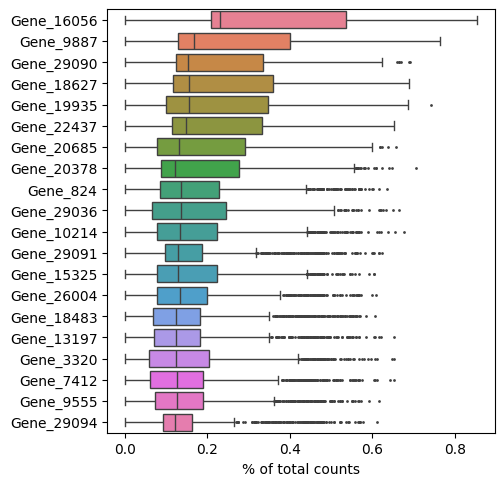

In [41]:
sc.pl.highest_expr_genes(a_data, n_top=20)


In [43]:
sc.pp.filter_cells(a_data, min_genes=200)
sc.pp.filter_genes(a_data, min_cells=3)

In [44]:
# annotate the group of mitochondrial genes as "mt"

a_data.var["mt"] = a_data.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    a_data, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

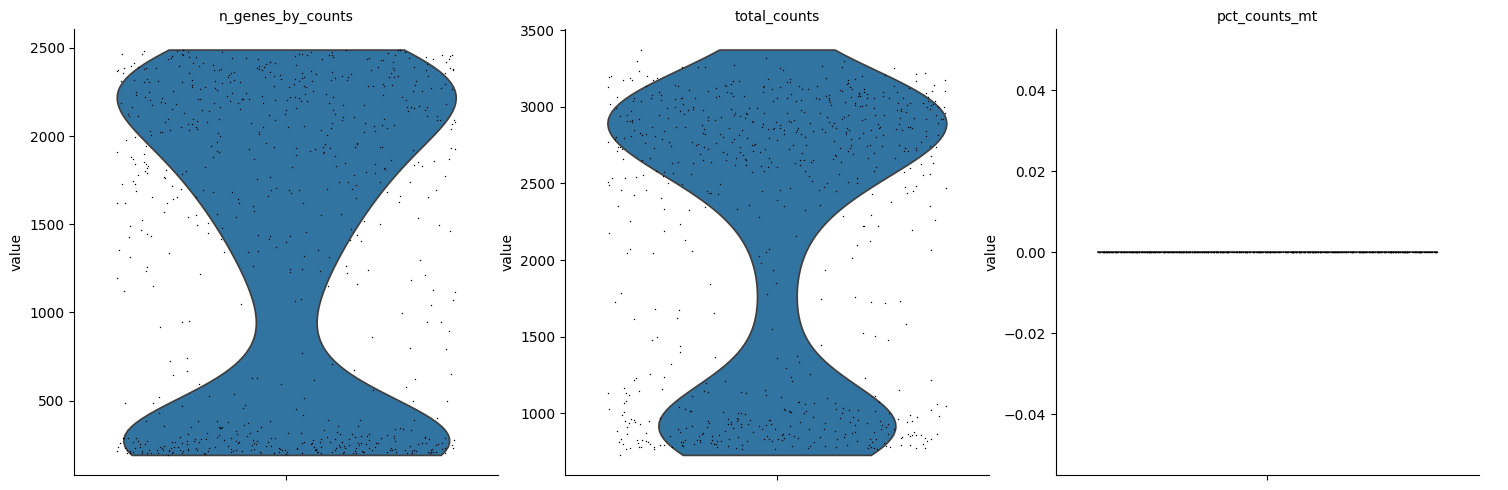

In [45]:
sc.pl.violin(
    a_data,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [46]:
# filtering ..

a_data = a_data[a_data.obs.n_genes_by_counts < 2500, :]
a_data = a_data[a_data.obs.pct_counts_mt < 5, :].copy()

In [47]:
# Total-count normalize (library-size correct) the data matrix
# to 10,000 reads per cell, so that counts become comparable among cells.

sc.pp.normalize_total(a_data, target_sum=1e4)

In [49]:
# Log. the data:
sc.pp.log1p(a_data)

# Identifying highly-variable genes
sc.pp.highly_variable_genes(a_data, min_mean=0.0125, max_mean=3, min_disp=0.5)

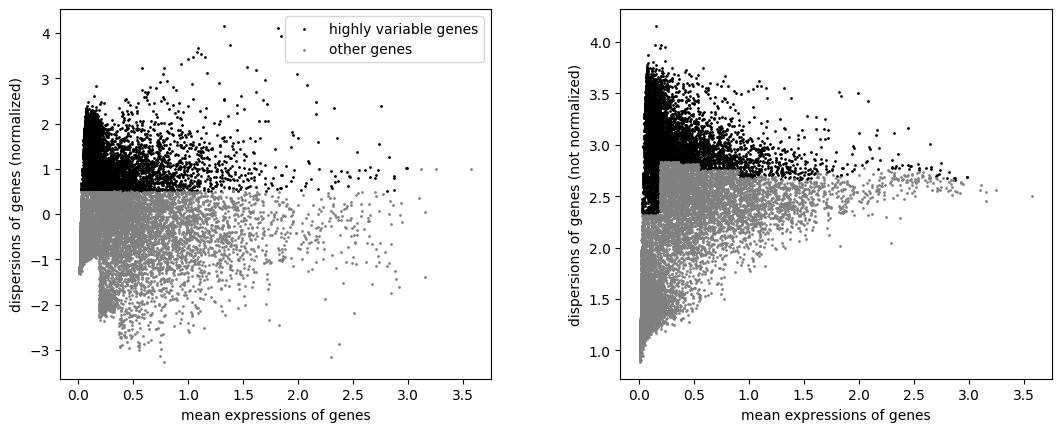

In [50]:
#plot them

sc.pl.highly_variable_genes(a_data)


In [51]:
a_data.raw = a_data

In [52]:
# more filtering..
a_data = a_data[:, a_data.var.highly_variable]


# Regress out effects of total counts per cell and the % of mit. genes expressed.
# Scaling then the data to unit variance.

sc.pp.regress_out(a_data, ["total_counts", "pct_counts_mt"])


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [53]:
# so, scaling data and clipping values exceeding standard deviation 10

sc.pp.scale(a_data, max_value=10)

In [54]:
#########

#######   PCA

sc.tl.pca(a_data, svd_solver="arpack")

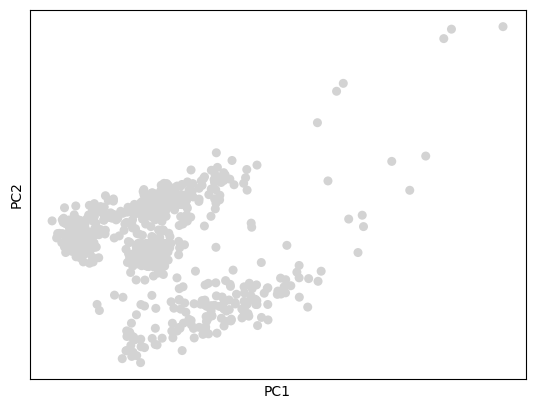

In [56]:

sc.pl.pca(a_data)


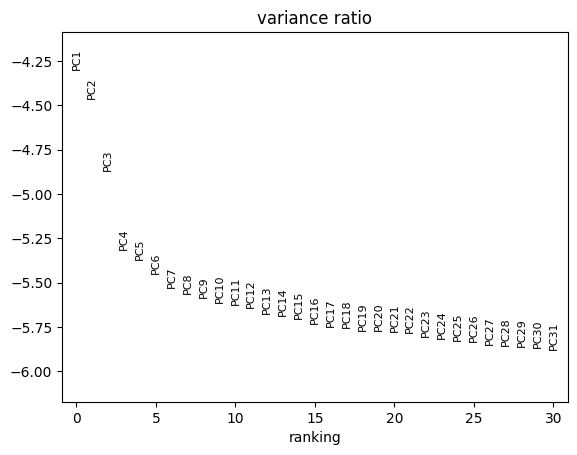

In [57]:

sc.pl.pca_variance_ratio(a_data, log=True)

In [59]:
# save results

a_data.write('results_file.hdf5')

In [60]:

a_data

AnnData object with n_obs × n_vars = 713 × 4798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [68]:
sc.tl.louvain(a_data)

In [69]:
## Computing the neighborhood graph of cells using
##  the PCA repr. of the data matrix

sc.pp.neighbors(a_data, n_neighbors=10, n_pcs=40)

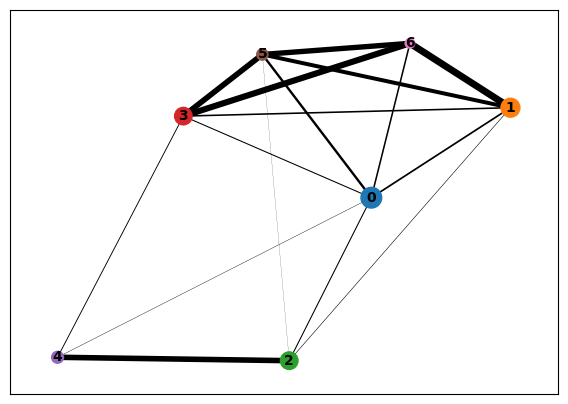

In [70]:
# embedding the graph in two dimensions using UMAP

sc.tl.paga(a_data)
sc.pl.paga(a_data)
sc.tl.umap(a_data, init_pos='paga')

In [77]:

sc.tl.umap(a_data)


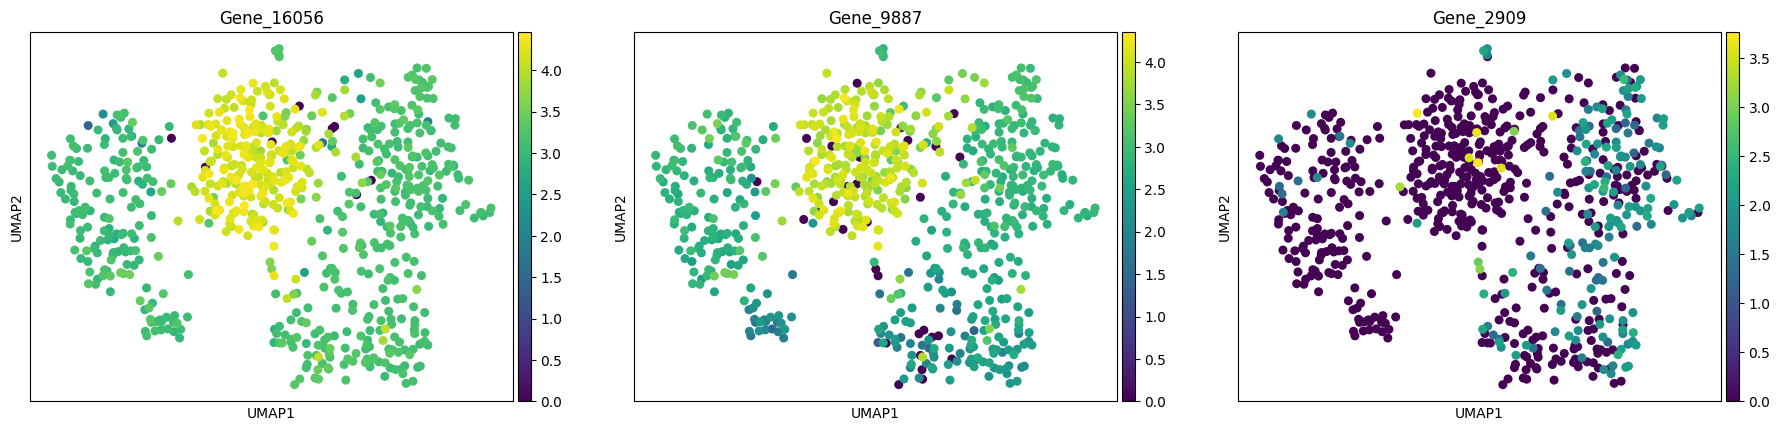

In [79]:

sc.pl.umap(a_data, color=["Gene_16056", "Gene_9887", "Gene_2909"])


In [80]:
# Clustering the neighborhood graph

sc.tl.leiden(
    a_data,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)


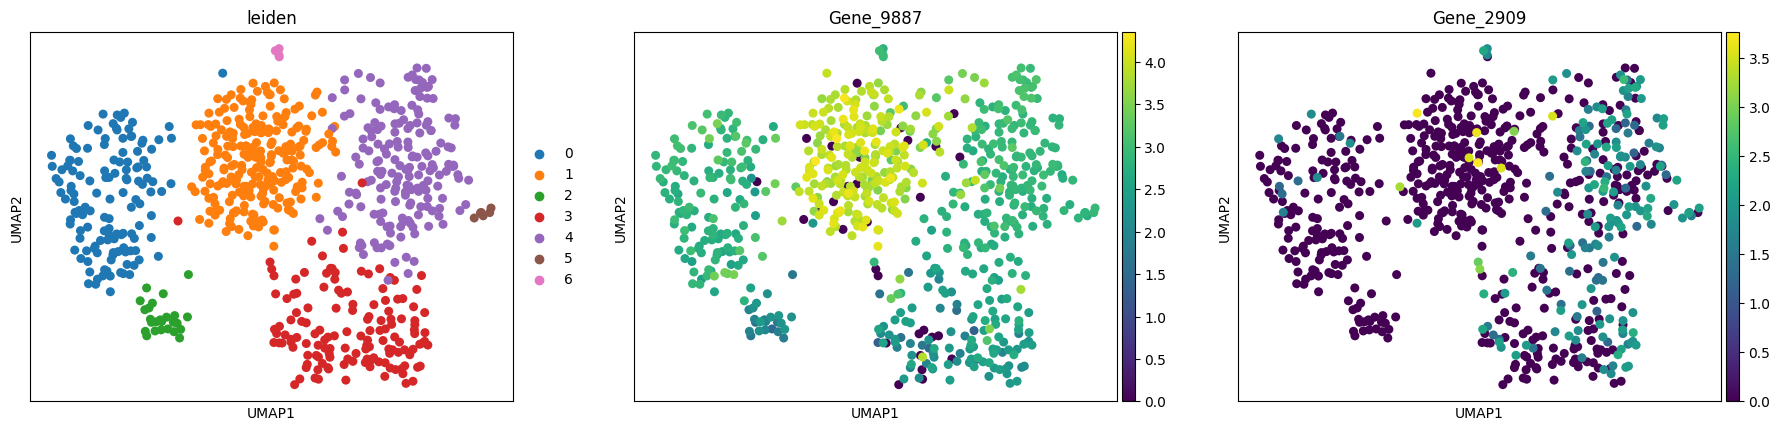

In [82]:
sc.pl.umap(a_data, color=["leiden", "Gene_9887", "Gene_2909"])

In [84]:


a_data.write('results.hdf5')


**Finding marker genes**
computing a ranking for the highly differential genes in each cluster.  .raw attribute of AnnData is used by default in case it has been initialized before. The simplest and fastest method is the t-test.


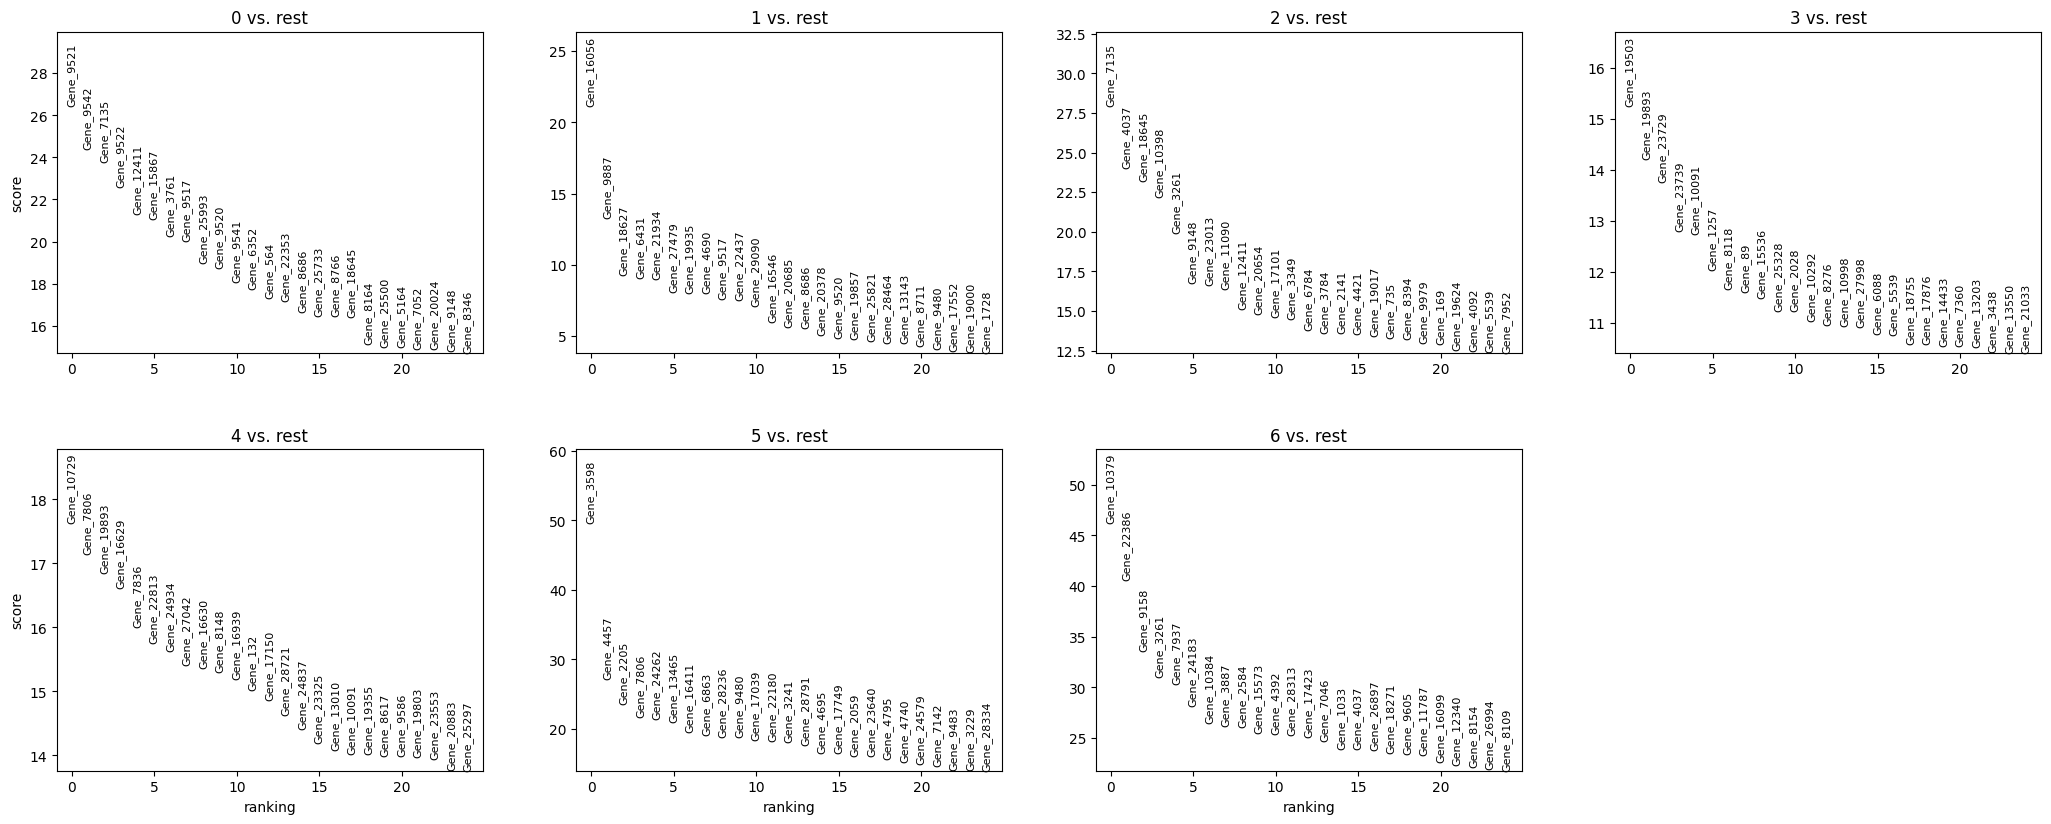

In [85]:

sc.tl.rank_genes_groups(a_data, "leiden", method="t-test")
sc.pl.rank_genes_groups(a_data, n_genes=25, sharey=False)

In [86]:
sc.settings.verbosity = 2

ranking genes
    finished (0:00:01)


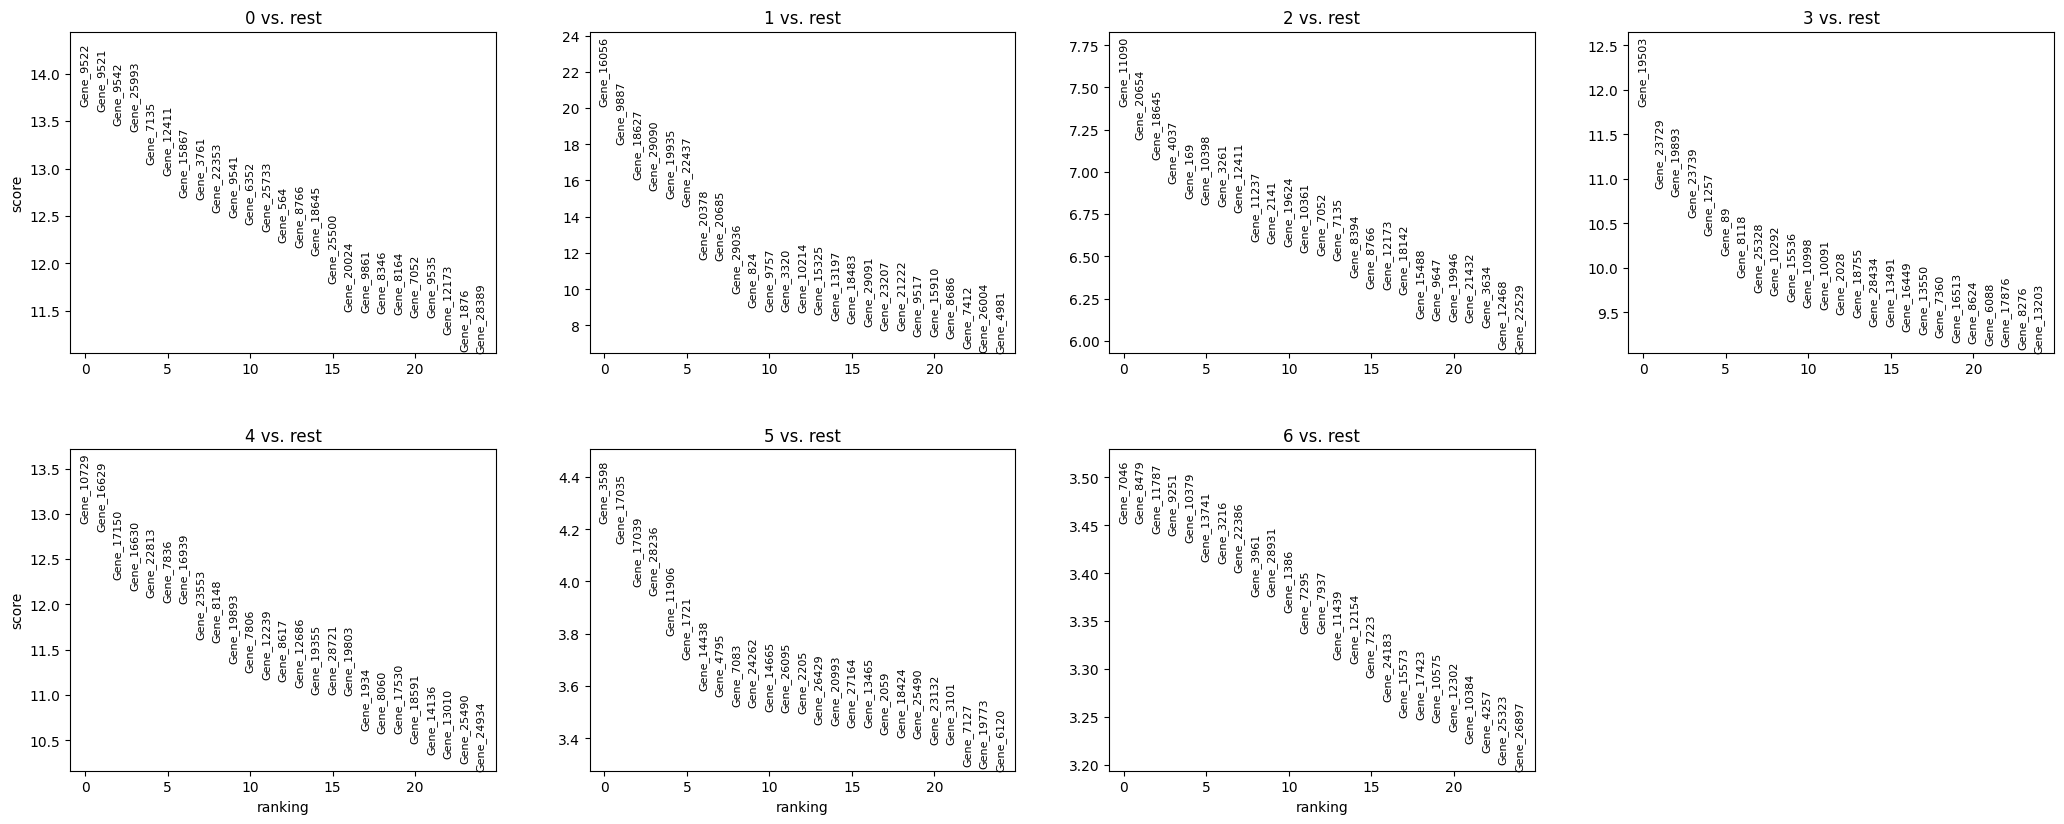

In [87]:

sc.tl.rank_genes_groups(a_data, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(a_data, n_genes=25, sharey=False)

In [88]:
a_data.write('results.hdf5')

ranking genes
    finished (0:01:00)


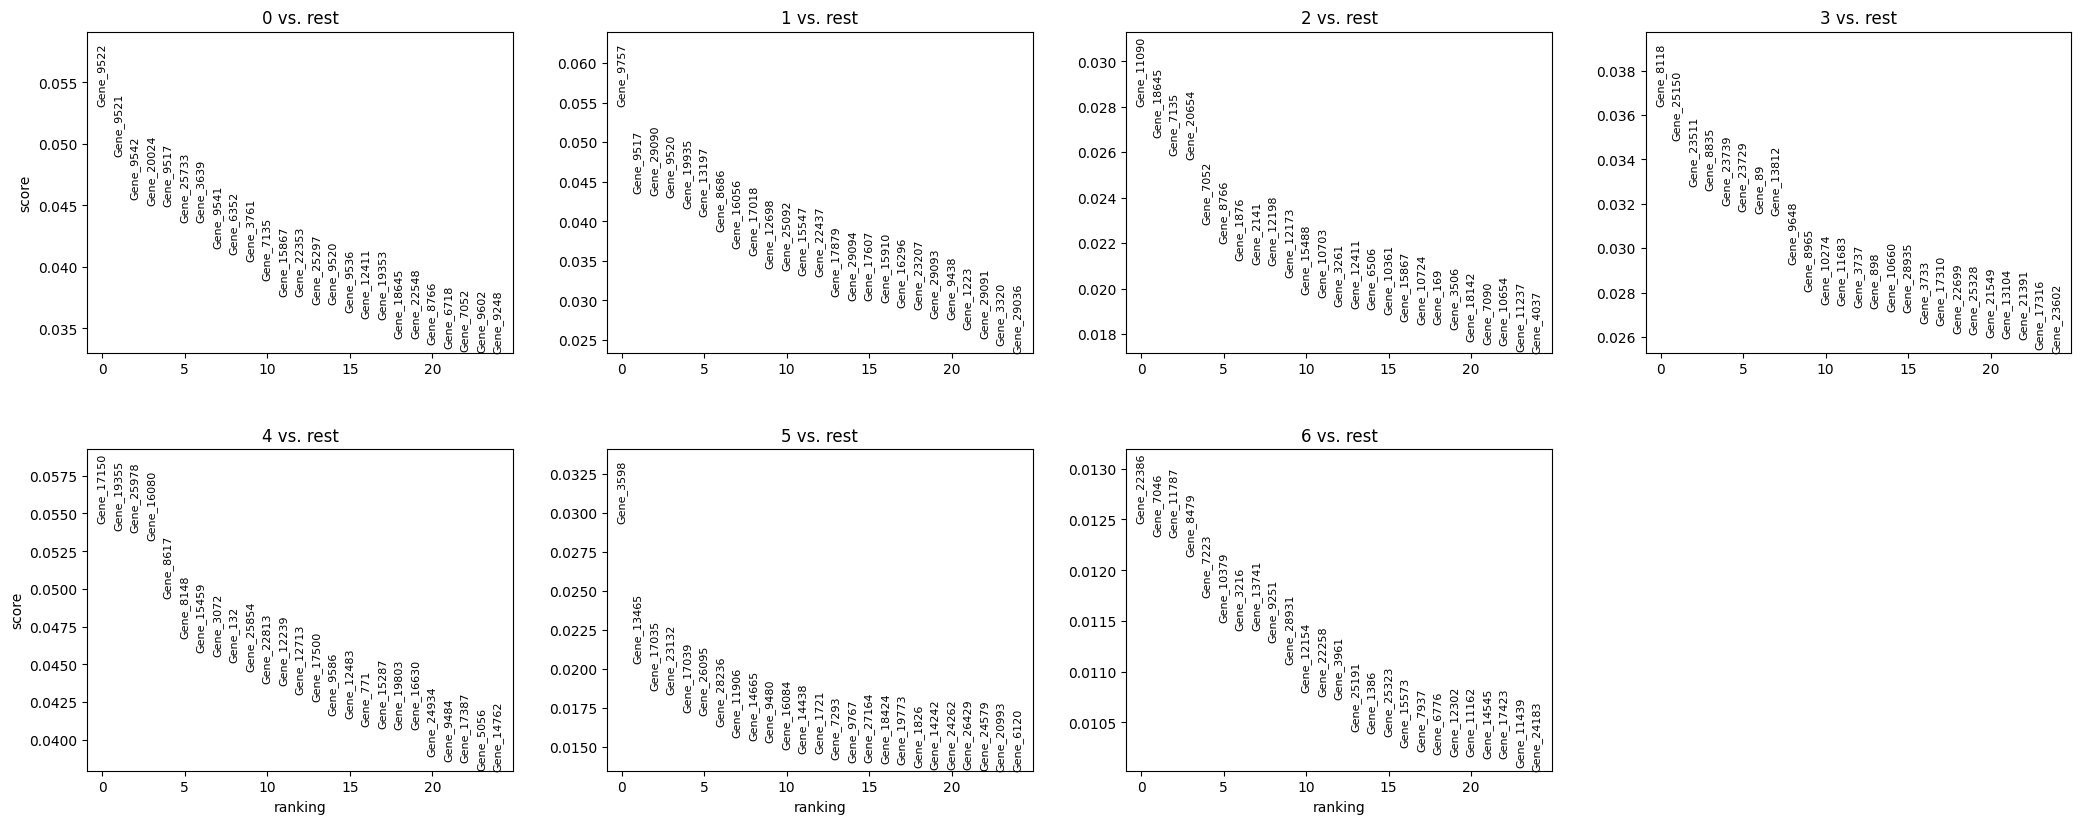

In [89]:


sc.tl.rank_genes_groups(a_data, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(a_data, n_genes=25, sharey=False)

In [111]:
marker_genes = [
    *["Gene_9522", "Gene_16056",	"Gene_11090",	"Gene_19503",	"Gene_10729",	"Gene_3598",	"Gene_7046"]
]

In [96]:
a_data = sc.read_h5ad('/content/results.hdf5')

In [97]:



pd.DataFrame(a_data.uns["rank_genes_groups"]["names"]).head(5)


,0,1,2,3,4,5,6
0,Gene_9522,Gene_16056,Gene_11090,Gene_19503,Gene_10729,Gene_3598,Gene_7046
1,Gene_9521,Gene_9887,Gene_20654,Gene_23729,Gene_16629,Gene_17035,Gene_8479
2,Gene_9542,Gene_18627,Gene_18645,Gene_19893,Gene_17150,Gene_17039,Gene_11787
3,Gene_25993,Gene_29090,Gene_4037,Gene_23739,Gene_16630,Gene_28236,Gene_9251
4,Gene_7135,Gene_19935,Gene_169,Gene_1257,Gene_22813,Gene_11906,Gene_10379


In [98]:
result = a_data.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p
0,Gene_9522,1.681611e-42,Gene_16056,4.207777e-90,Gene_11090,1.446218e-13,Gene_19503,3.021548e-32,Gene_10729,4.886868e-38,Gene_3598,0.000024,Gene_7046,0.000557
1,Gene_9521,3.655379e-42,Gene_9887,1.994549e-72,Gene_20654,6.232277e-13,Gene_23729,1.147723e-27,Gene_16629,1.423735e-37,Gene_17035,0.000034,Gene_8479,0.000557
2,Gene_9542,2.805685e-41,Gene_18627,3.342711e-58,Gene_18645,1.487036e-12,Gene_19893,3.103269e-27,Gene_17150,1.215632e-34,Gene_17039,0.000068,Gene_11787,0.000577
3,Gene_25993,6.925274e-41,Gene_29090,5.091573e-54,Gene_4037,4.081295e-12,Gene_23739,4.377784e-26,Gene_16630,5.073280e-34,Gene_28236,0.000079,Gene_9251,0.000582
4,Gene_7135,6.628745e-39,Gene_19935,7.580512e-51,Gene_169,7.627725e-12,Gene_1257,3.629375e-25,Gene_22813,1.288703e-33,Gene_11906,0.000147,Gene_10379,0.000598


ranking genes
    finished (0:00:00)


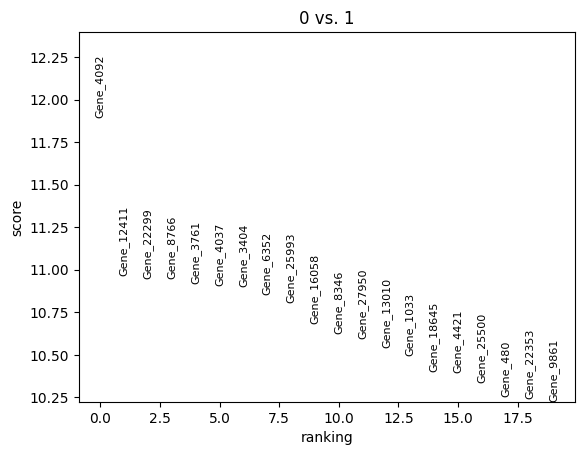

In [99]:


sc.tl.rank_genes_groups(a_data, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(a_data, groups=["0"], n_genes=20)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


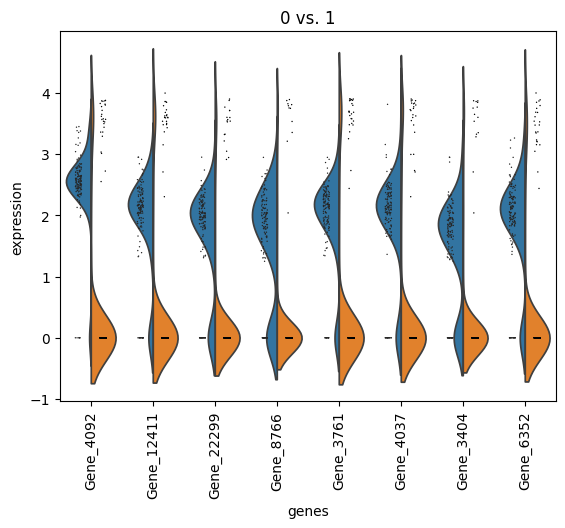

In [100]:

sc.pl.rank_genes_groups_violin(a_data, groups="0", n_genes=8)


In [101]:


a_data = sc.read_h5ad('/content/results.hdf5')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


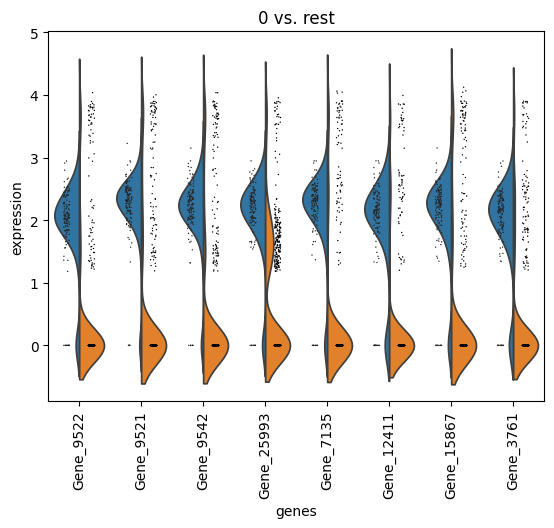

In [102]:


sc.pl.rank_genes_groups_violin(a_data, groups="0", n_genes=8)


In [104]:

new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    #"Megakaryocytes",
]
a_data.rename_categories("leiden", new_cluster_names)

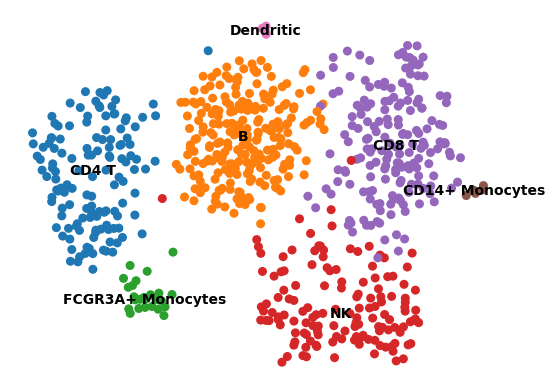

In [105]:


sc.pl.umap(
    a_data, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

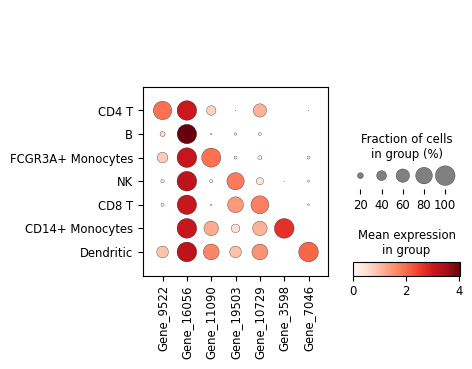

In [112]:


# Visualize marker genes
sc.pl.dotplot(a_data, marker_genes, groupby='leiden')


In [113]:
a_data

AnnData object with n_obs × n_vars = 713 × 4798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [118]:

library_sizes = np.sum(a_data.X, axis=1)
size_factors = library_sizes / np.median(library_sizes)


In [123]:


encoder_louvain = LabelEncoder()
encoder_louvain.fit(a_data.obs['louvain'])

encoder_leiden = LabelEncoder()
encoder_leiden.fit(a_data.obs['leiden'])


LabelEncoder()

In [124]:
encoders = {
    'obs': {
        'louvain': encoder_louvain.transform,
        'leiden': encoder_leiden.transform
    }
}


In [196]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class CVAE(Model):
    def __init__(self, latent_dim, num_clusters, input_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_clusters = num_clusters
        self.input_dim = input_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        input_data = layers.Input(shape=(self.input_dim,))
        input_cluster = layers.Input(shape=(self.num_clusters,))
        x = layers.Concatenate()([input_data, input_cluster])
        x = layers.Dense(256, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim)(x)
        z_log_var = layers.Dense(self.latent_dim)(x)
        return Model(inputs=[input_data, input_cluster], outputs=[z_mean, z_log_var])

    def build_decoder(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        input_cluster = layers.Input(shape=(self.num_clusters,))
        x = layers.Concatenate()([latent_inputs, input_cluster])
        x = layers.Dense(256, activation='relu')(x)
        output = layers.Dense(self.input_dim, activation='sigmoid')(x)
        return Model(inputs=[latent_inputs, input_cluster], outputs=output)

    def sample(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        input_data, input_cluster = inputs
        z_mean, z_log_var = self.encoder([input_data, input_cluster])
        z = self.sample(z_mean, z_log_var)
        reconstructed = self.decoder([z, input_cluster])
        return reconstructed

data = np.array(x_data)
clusters = np.array(clusters_data)
size_factors = np.array(size_factors_data)

# Defining the dimensions
input_dim = data.shape[1]
latent_dim = 10
num_clusters = clusters.shape[1]

# Instantiating the CVAE model
cvae_model = CVAE(latent_dim, num_clusters, input_dim)

# optimizer
optimizer = tf.keras.optimizers.Adam()

#  loss function (e.g., Mean Squared Error)
mse_loss_fn = tf.keras.losses.MeanSquaredError()


# Compile
cvae_model.compile(optimizer=optimizer, loss=mse_loss_fn)

# Train
history = cvae_model.fit([data, clusters], data, epochs=20, batch_size=125)


Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9645
Epoch 2/20
1/1 [==============================] - 0s 23ms/step - loss: 0.8992
Epoch 3/20
1/1 [==============================] - 0s 31ms/step - loss: 0.8063
Epoch 4/20
1/1 [==============================] - 0s 18ms/step - loss: 0.6249
Epoch 5/20
1/1 [==============================] - 0s 21ms/step - loss: 0.7566
Epoch 6/20
1/1 [==============================] - 0s 19ms/step - loss: 0.4773
Epoch 7/20
1/1 [==============================] - 0s 20ms/step - loss: 0.4225
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.6150
Epoch 9/20
1/1 [==============================] - 0s 18ms/step - loss: 0.3960
Epoch 10/20
1/1 [==============================] - 0s 18ms/step - loss: 0.5649
Epoch 11/20
1/1 [==============================] - 0s 18ms/step - loss: 0.3890
Epoch 12/20
1/1 [==============================] - 0s 19ms/step - loss: 0.5268
Epoch 13/20
1/1 [==============================] - 0s 20ms/step